In [1]:
import torch
from gameds import GameDS
from transforms import PatchTransform
from helpers import plotframes
import random
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader
ds = GameDS()
train_dataloader = DataLoader(ds, batch_size=24, shuffle=True, prefetch_factor=10, num_workers=12)

In [3]:
# Hyperparameters
NUM_FRAMES = 10
COLOR_CHANNELS = 3
IMG_SIZE = 256
PATCH_SIZE = 16

D_DIM = 128
EMBEDDING_DIM = 32
PATCH_KEEP_PERCENTAGE = 0.5

NUM_PATCHES = int((IMG_SIZE / PATCH_SIZE) * (IMG_SIZE / PATCH_SIZE))*NUM_FRAMES

LEARNING_RATE = 1e-4

In [4]:
# Define the Model
P = torch.nn.Linear(PATCH_SIZE*PATCH_SIZE*COLOR_CHANNELS, D_DIM).to("cuda")
P_invert = torch.nn.Linear(D_DIM, PATCH_SIZE*PATCH_SIZE*COLOR_CHANNELS).to("cuda")

Embedding = torch.nn.Embedding(NUM_PATCHES, EMBEDDING_DIM).to("cuda")

encoder_layer = torch.nn.TransformerEncoderLayer(D_DIM + EMBEDDING_DIM, 2, dim_feedforward=2048, dropout=0.1)
transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, 3).to("cuda")

decoder_layer = torch.nn.TransformerEncoderLayer(D_DIM + EMBEDDING_DIM, 2, dim_feedforward=2048, dropout=0.1)
transformer_decoder = torch.nn.TransformerEncoder(decoder_layer, 3).to("cuda")

/home/constantin/Documents/celltracking/celltracking/helpers.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  ax.flat[idx].imshow(X[0, idx].T.cpu().detach().numpy())


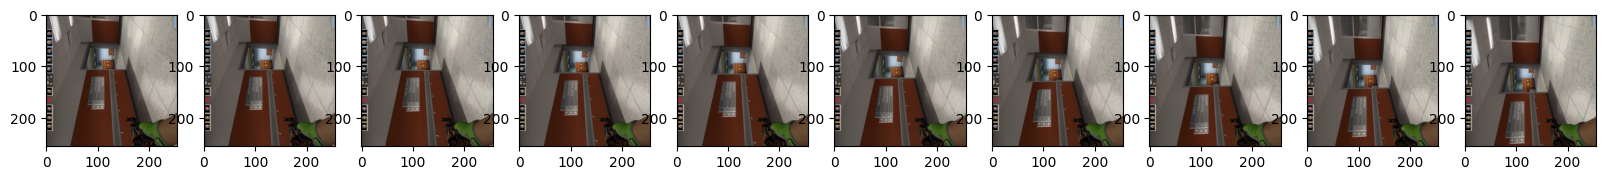

torch.Size([24, 10, 3, 256, 256])
torch.Size([24, 10, 3, 256, 256])


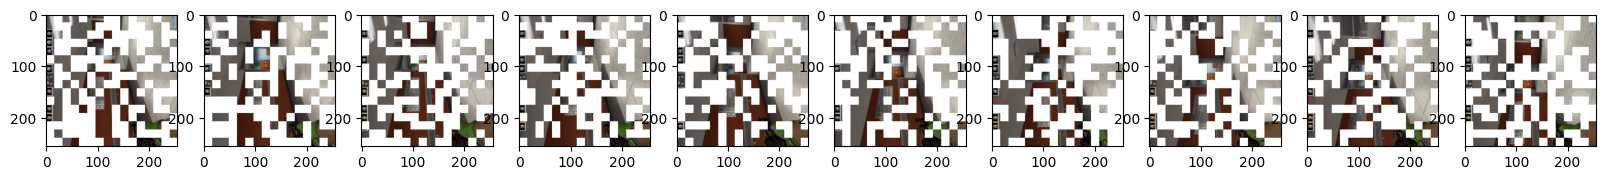

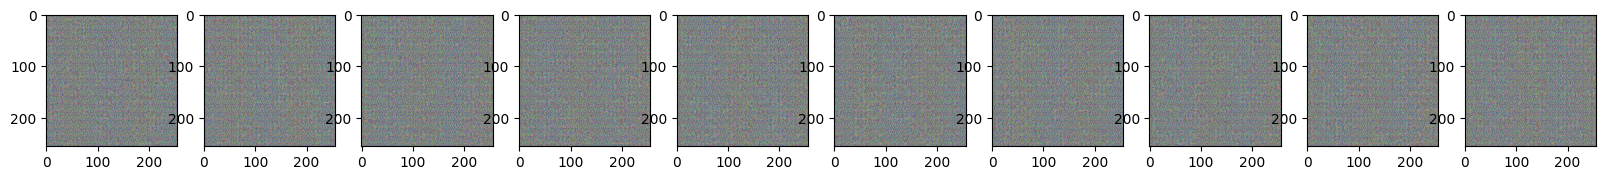

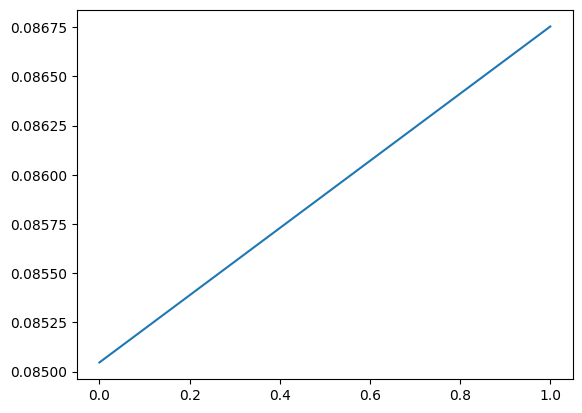

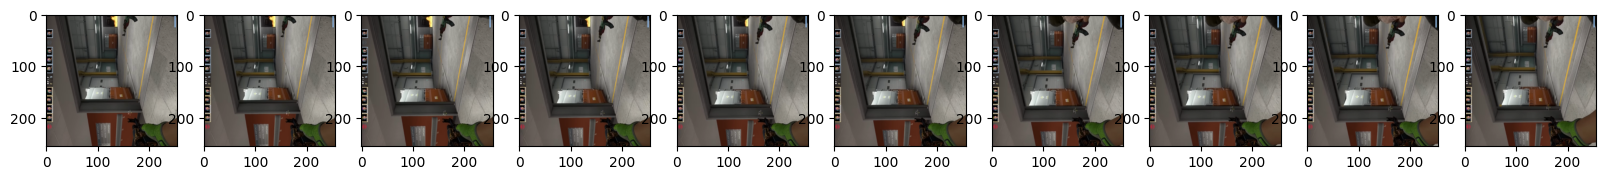

torch.Size([24, 10, 3, 256, 256])
torch.Size([24, 10, 3, 256, 256])


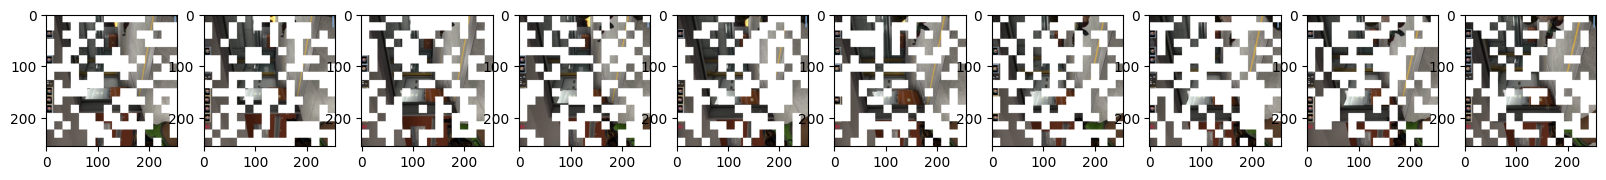

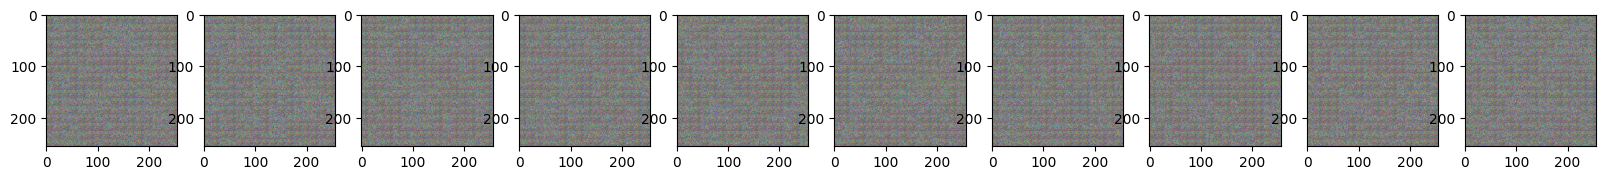

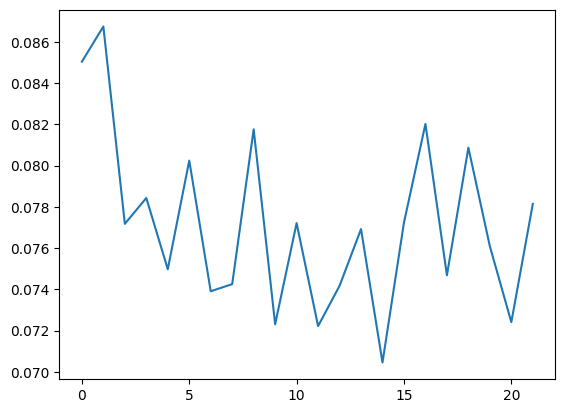

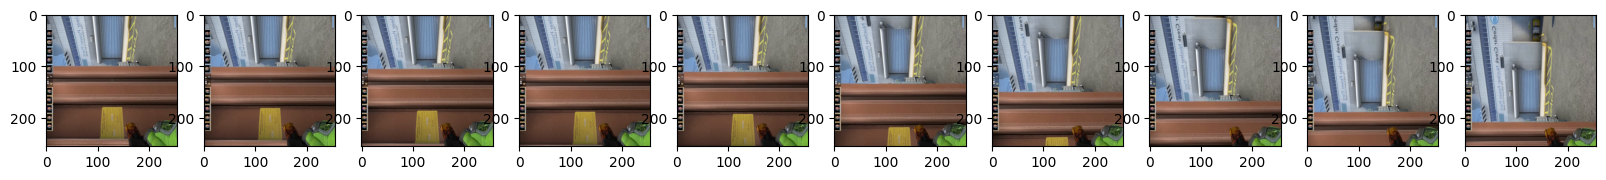

torch.Size([24, 10, 3, 256, 256])
torch.Size([24, 10, 3, 256, 256])


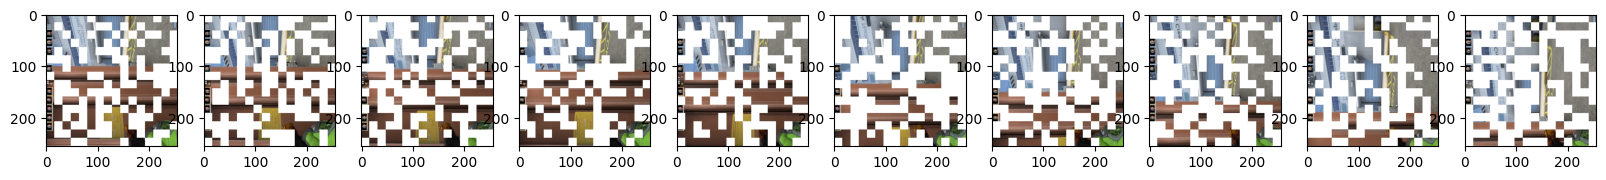

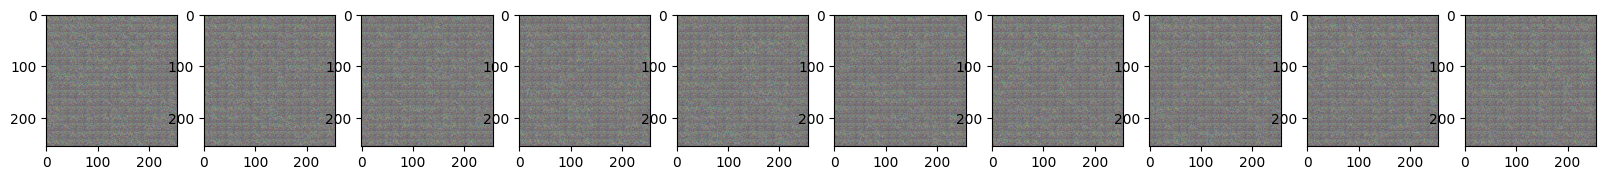

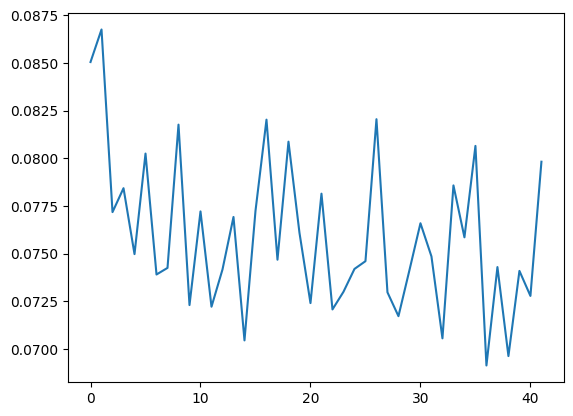

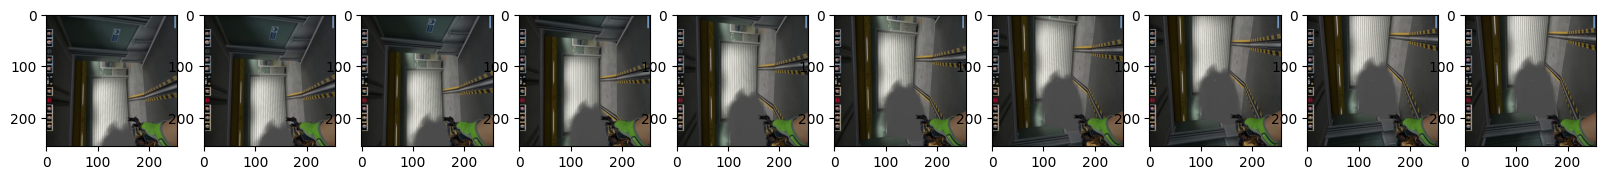

torch.Size([24, 10, 3, 256, 256])
torch.Size([24, 10, 3, 256, 256])


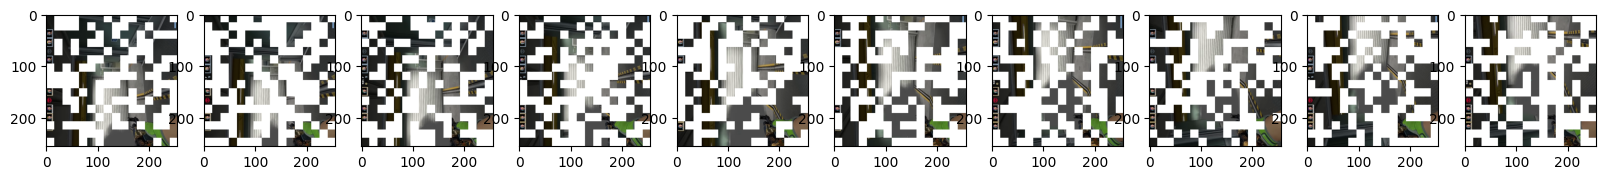

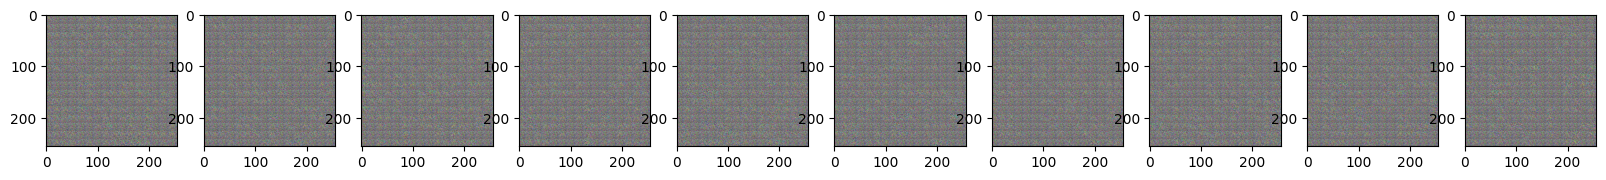

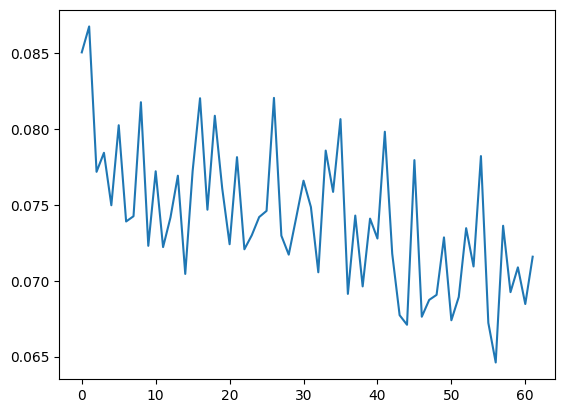

In [ ]:
## Train loop

pt = PatchTransform(PATCH_SIZE, IMG_SIZE, COLOR_CHANNELS)

# Define optimizer and loss
criterion = torch.nn.MSELoss()
params = list(P.parameters())
params += list(P_invert.parameters())
params += list(Embedding.parameters())
params += list(transformer_encoder.parameters())
params += list(transformer_decoder.parameters())
optim = torch.optim.Adam(params=params, lr=LEARNING_RATE)

losses = []

for epoch in range(100):
    for i_iter, (X, y) in enumerate(iter(train_dataloader)):
        X = X / 255
        X = X.to("cuda")
        
        optim.zero_grad()
        X_for_loss_calculation = X.clone()
        
        # Create, flatten and project the patches
        patches = pt(X)
        patches_shape_unflattened = patches.shape
        patches_flattened = torch.flatten(patches, start_dim=2)
        patches_flattened = P(patches_flattened)
        
        batch_size, num_patches, _ = patches_flattened.shape
        
        # Add positional embeddings to the patches
        indices = torch.arange(num_patches).to("cuda")
        embedded_vectors = Embedding(indices)
        embedded_vectors = embedded_vectors.repeat(batch_size, 1, 1)
        X = torch.cat([patches_flattened, embedded_vectors], dim=-1)
        
        # Randomly select to keep n percent of the patches
        num_patches = X.shape[1]
        patches_to_keep = [random.random() < PATCH_KEEP_PERCENTAGE for _ in range(num_patches)]
        patches_to_keep_inverted = [not x for x in patches_to_keep]
        X_for_encoder = X[:, patches_to_keep].clone()
        
        X_blinded_for_display = patches.clone()
        X_blinded_for_display[:, patches_to_keep_inverted] = 1
        X_blinded_for_display = pt.invert(X_blinded_for_display)
        
        X_for_decoder = X.clone()
        X_for_decoder[:, patches_to_keep_inverted] = 0
        
        #print(X_for_encoder.shape, X_for_decoder.shape)
        
        representation_after_encoder = transformer_encoder(X_for_encoder)
        
        # Mix the encoder representation into the decoder input (which is blinded)
        index_pointer = 0
        for idx, keep in enumerate(patches_to_keep):
            if keep:
                X_for_decoder[:, idx] = representation_after_encoder[:, index_pointer]
                index_pointer += 1
        decoder_representation = transformer_decoder(X_for_decoder)
        
        # project and reshape to original size and shape
        decoder_representation = decoder_representation[:, :, :D_DIM]
        decoder_representation = P_invert(decoder_representation)
        decoder_representation = torch.sigmoid(decoder_representation)
        decoder_representation = decoder_representation.reshape(patches_shape_unflattened)
        
        decoder_patches = pt.invert(decoder_representation)
        
        
        
        #print("For loss calculation:", decoder_patches.shape, X_for_loss_calculation.shape)
    
        X_for_loss_calculation = X_for_loss_calculation.to("cuda")
        decoder_patches = decoder_patches.to("cuda")
        
        loss = criterion(decoder_patches.reshape(-1, COLOR_CHANNELS, IMG_SIZE, IMG_SIZE), X_for_loss_calculation.reshape(-1, COLOR_CHANNELS, IMG_SIZE, IMG_SIZE))
        #loss = criterion(decoder_patches, X_for_loss_calculation)
        loss.backward()
        if i_iter%20 == 1:
            optim.step()
        
        print(i_iter, loss.item(), end="\r")
        losses.append(loss.item())

        if i_iter%20 == 1:
            plotframes(X_for_loss_calculation)
            print(X_for_loss_calculation.shape)
            print(X_blinded_for_display.shape)
            plotframes(X_blinded_for_display)
            plotframes(decoder_patches)

            plt.plot(losses)
            plt.show()